In [1]:
DATA_PATH = "./data/"
OUTPUT_PATH = "./out/"

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

In [8]:
dfStim = pd.read_pickle(DATA_PATH  + "data_01_stim.pkl")

lst = dfStim.VisualStimuliPosition.unique()
dfStim["VisualStimuliId"] = -1
for i in range(len(lst)):
    dfStim.loc[dfStim.VisualStimuliPosition == lst[i], "VisualStimuliId"] = i

dfStim.VisualStimuliPositionX = 1.9 * dfStim.VisualStimuliPositionX
dfStim.VisualStimuliPositionY = 1.9 * dfStim.VisualStimuliPositionY
dfStim.TouchX = 1.9 * dfStim.TouchX
dfStim.TouchY = 1.9 * dfStim.TouchY

dfStim["TouchOffset"] = np.sqrt(((dfStim.TouchX - dfStim.VisualStimuliPositionX).pow(2) + (dfStim.TouchY - dfStim.VisualStimuliPositionY).pow(2)))

dfAcc = pd.read_pickle(DATA_PATH  + "data_01_acc.pkl")
timeMins = [897, 1021, 1186, 909, 1092]
timeMaxs = [3232, 2818, 2744, 2341, 2483] #[2737, 2325, 2262, 1822, 1950]

In [9]:
dfStim.TouchType.value_counts()

1    55569
2     9712
0     9712
Name: TouchType, dtype: int64

In [10]:
dfTCT = dfStim[dfStim.TouchType == 2].groupby(["PId", "SpeedCondition", "IsBump","TouchId", "VisualStimuliId"])["TCT"].max().reset_index()
dfTCT = dfTCT.groupby(["PId", "IsBump", "SpeedCondition", "VisualStimuliId"]).mean().reset_index()

path = DATA_PATH + "R_TCT.csv"
print(path)
dfTCT.to_csv(path, index=None)
dfTCT.groupby("IsBump")["TCT"].describe()/1000

./data/R_TCT.csv


,count,mean,std,min,25%,50%,75%,max
IsBump,,,,,,,,
0.0,2.084,1.286838,0.503821,0.5475,1.007000,1.152417,1.381000,6.066
1.0,2.339,1.318172,0.413016,0.7040,1.024833,1.190500,1.499125,3.919


In [11]:
dfs = []
for i in range(5):
    s = ((i+1) *10)
    df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.IsBump == 1)]
    df2 = df2[(df2.TimeRelativ > 0)].copy()
    dfs.append(df2)
dfStimFilter = pd.concat(dfs)

In [12]:
dfStim["IsBumpVirtual"] = dfStim.IsBump

dfStim.loc[dfStim.IsBump == 1, "IsBumpVirtual"] = 0.0
dfStim.loc[dfStim.TouchId.isin(dfStimFilter.TouchId.unique()), "IsBumpVirtual"] = 1.0
dfStim.groupby(["IsBump", "IsBumpVirtual"]).count()

SpeedCondition  TimeOfBump  TimeOfVisual  \
IsBump IsBumpVirtual                                             
0.0    0.0                     29005       29005         29005   
1.0    0.0                      6912        6912          6912   
       1.0                     39076       39076         39076   

                      VisualStimuliCondition  VisualStimuliPosition  \
IsBump IsBumpVirtual                                                  
0.0    0.0                             29005                  29005   
1.0    0.0                              6912                   6912   
       1.0                             39076                  39076   

                      VisualStimuliPositionX  VisualStimuliPositionY  \
IsBump IsBumpVirtual                                                   
0.0    0.0                             29005                   29005   
1.0    0.0                              6912                    6912   
       1.0                             39076                   39076   

                      TimeOfTouch  TouchX  TouchY       ...           TCT  \
IsBump IsBumpVirtual                                    ...                 
0.0    0.0                  29005   29005   29005       ...         29005   
1.0    0.0                   6912    6912    6912       ...          6912   
       1.0                  39076   39076   39076       ...         39076   

                      TouchOffset  TouchId  TimeShift  TimeRelativ  \
IsBump IsBumpVirtual                                                 
0.0    0.0                  29005    29005      29005        29005   
1.0    0.0                   6912     6912       6912         6912   
       1.0                  39076    39076      39076        39076   

                      TimeRelativBack  TimeStart  TimeEnd  AccDiff  \
IsBump IsBumpVirtual                                                 
0.0    0.0                      29005      29005    29005    22112   
1.0    0.0                       6912       6912     6912        3   
       1.0                      39076      39076    39076    35123   

                      VisualStimuliId  
IsBump IsBumpVirtual                   
0.0    0.0                      29005  
1.0    0.0                       6912  
       1.0                      39076  

[3 rows x 27 columns]

In [13]:
print("Samples without bump before:")
(len(dfStim[(dfStim.IsBumpVirtual == 0) & (dfStim.IsBump == 1)].TouchId.unique())/len(dfStim[(dfStim.IsBump == 1)].TouchId.unique()))*100

Samples without bump before:


16.845248550851924

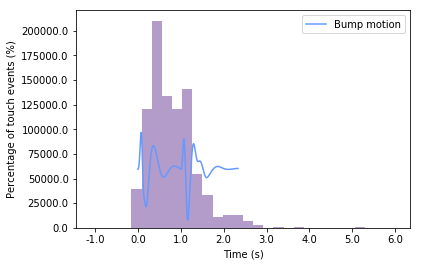

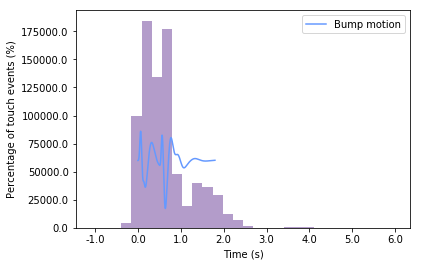

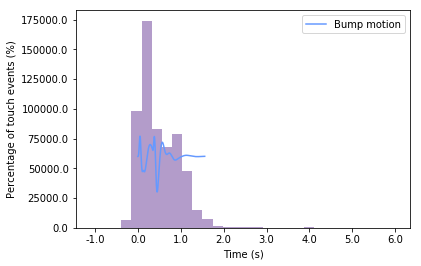

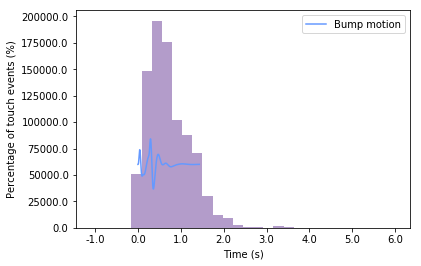

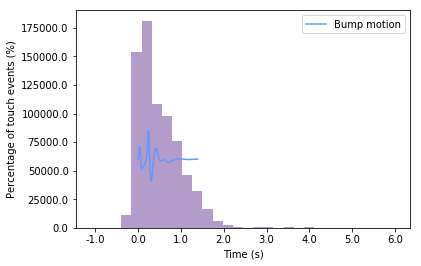

In [14]:
for i in range(5):
    s = ((i+1) *10)
    
    fig, ax = plt.subplots()
    df = dfAcc[dfAcc.Speed == s]
    plt.plot(df.Time, (df.Acc+3)*200.0, label="Bump motion", c=colorDic["blue"])

    
    df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.IsBumpVirtual == 1.0)]

    plt.hist(df2.TimeRelativ, 30, color=colorDic["purple"], alpha=0.5, range=(-1100,6000))
   
    plt.xlabel("Time (s)")
    plt.ylabel("Percentage of touch events (%)")
    ax.set_xticklabels(ax.get_xticks() /1000)
    ax.set_yticklabels(ax.get_yticks() *100)
    
    plt.legend()
    plt.show()

In [15]:
dfStim.index = range(len(dfStim))
dfStim["TouchEventId"] = range(len(dfStim))
dfStim["TouchOffsetX"] = dfStim.TouchX - dfStim.VisualStimuliPositionX 
dfStim["TouchOffsetY"] = dfStim.TouchY - dfStim.VisualStimuliPositionY

In [16]:
dfF = dfAcc.groupby("Speed").max()
dfF

,Time,Acc,Diff
Speed,,,
10,2334,1.839587,0.049702
20,1796,1.302030,0.048290
30,1557,0.849509,0.034685
40,1431,1.206069,0.031616
50,1390,1.231993,0.045879


In [17]:
TouchEventId = dfStim.groupby(["TouchId"])["TouchEventId"].max().values

In [18]:
TouchIdFilter = []
for s in dfStim.SpeedCondition.unique():
    x = dfStim[dfStim.TouchEventId.isin(TouchEventId) & (dfStim.TimeRelativ < dfF.loc[s].Time) & (dfStim.SpeedCondition == s)].TouchId.values
    TouchIdFilter.append(x)
TouchIdFilter = np.concatenate(TouchIdFilter)

print("%.2f %% late touches removed" %((1-(len(TouchIdFilter) /len(TouchEventId)))*100))

dfStimFiltered = dfStim[dfStim.TouchId.isin(TouchIdFilter)]

print("%.2f %% removed touch events due to the last was late" %((1-(len(dfStimFiltered) /len(dfStim)))*100))

4.67 % late touches removed
5.10 % removed touch events due to the last was late


In [19]:
TouchEventId = dfStimFiltered.groupby(["TouchId"])["TouchEventId"].max().values
df2 = dfStimFiltered[dfStimFiltered.TouchEventId.isin(TouchEventId)][["TouchId", "TouchOffsetX", "TouchOffsetY", "TouchOffset", "SpeedCondition", "IsBumpVirtual"]]
f = df2.TouchOffset.describe()
print(f)
print("\nUpper limit %.2f \n" % (f["mean"] + 2 * f["std"]))
df3 = df2[df2.TouchOffset < f["mean"] + 2 * f["std"]]
print(df3.TouchOffset.describe())
print((len(df2)))
print((len(df3)))

print(len(df3) -len(df2))
print(1-(len(df3) /len(df2)))
print("%.2f %% of all touch downs removed samples" %((1-(len(df3) /len(df2)))*100))

count    9052.000000
mean       49.911311
std        65.198951
min         0.000000
25%        22.835158
50%        39.271774
75%        63.104921
max      2704.754534
Name: TouchOffset, dtype: float64

Upper limit 180.31 

count    8975.000000
mean       46.565642
std        32.146447
min         0.000000
25%        22.658822
50%        38.964157
75%        62.118346
max       180.249827
Name: TouchOffset, dtype: float64
9052
8975
-77
0.008506407423773732
0.85 % of all touch downs removed samples


In [20]:
df3.TouchOffset.describe()

count    8975.000000
mean       46.565642
std        32.146447
min         0.000000
25%        22.658822
50%        38.964157
75%        62.118346
max       180.249827
Name: TouchOffset, dtype: float64

In [21]:
dfStimFiltered2 = dfStimFiltered[dfStimFiltered.TouchId.isin(df3.TouchId)]
print((len(dfStim)))
print((len(dfStimFiltered)))
print("%.2f %% of all toch events removed" %((1-(len(dfStimFiltered2) /len(dfStimFiltered)))*100))

74993
71171
0.89 % of all toch events removed


In [22]:
dfStimFiltered2.to_pickle(DATA_PATH  + "data_02_stim.pkl")